In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata
from scanpy import read_10x_h5
import anndata as ad

### data preprocess

In [2]:
filepath = './data'
adata1 = sc.read(f'{filepath}/Stereo-seq_MoB.h5ad')
adata2 = sc.read(f'{filepath}/Slide-seqV2_MoB.h5ad')

In [3]:
sc.pp.calculate_qc_metrics(adata1, inplace=True)
sc.pp.calculate_qc_metrics(adata2, inplace=True)

sc.pp.filter_cells(adata1, min_genes=100)
sc.pp.filter_genes(adata1, min_cells=50)
print('After flitering: ', adata1.shape)
# 处理数据
sc.pp.highly_variable_genes(adata1, flavor="seurat_v3", n_top_genes=7000)
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)  #将数据矩阵对数化
# sc.pp.pca(adata1)

# 过滤数据
sc.pp.filter_cells(adata2, min_genes=100)  #min_counts:细胞通过过滤所需的最小counts数  min_genes:细胞通过过滤所需的最小表达基因数
sc.pp.filter_genes(adata2, min_cells=50)
print('After flitering: ', adata2.shape)
# 处理数据
sc.pp.highly_variable_genes(adata2, flavor="seurat_v3", n_top_genes=7000)
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)  #将数据矩阵对数化

After flitering:  (18109, 14345)


d:\Users\spec\anaconda3\envs\spamc\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


After flitering:  (14154, 11666)


In [4]:
adata1 = adata1[:, adata1.var.highly_variable]
adata2 = adata2[:, adata2.var.highly_variable]

intersection = adata1.var_names.intersection(adata2.var_names)

adata1_svg = adata1[:,intersection]
adata2_svg = adata2[:,intersection]

adata_new1 = adata1_svg.concatenate(adata2_svg, index_unique=None)

section_ids = ['stereo','slide']
print(section_ids)
adata1_svg.obs_names = [x+'_'+section_ids[0] for x in adata1_svg.obs_names]
adata2_svg.obs_names = [x+'_'+section_ids[1] for x in adata2_svg.obs_names]

d:\Users\spec\anaconda3\envs\spamc\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


['stereo', 'slide']


In [5]:
import anndata as ad
Batch_list = [adata1_svg, adata2_svg]
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (32263, 3236)


In [6]:
n1 =adata1_svg.X.shape[0]
n2 =adata2_svg.X.shape[0]

In [21]:
# n1 = 18109
# n2 = 14154
n1+n2

32263

In [7]:
n1+n2

32263

In [8]:

adata = adata_concat
adata.write(f'{filepath}/stereo_slide/adata_cat.h5ad')

### start_training

In [2]:
import torch
from scipy.sparse import csr_matrix
def load_data(filepath):
    adata = sc.read_h5ad(f'{filepath}/adata_cat.h5ad')
    print('finish reading h5ad')
    # sub_graph_df = pd.read_pickle(f'{filepath}/sub_graph_7k.pickle')
    # sub_graph = sub_graph_df.values
    # print(f'sub_graph shape:{sub_graph.shape}')
    # sub_graph = torch.from_numpy(sub_graph)
    if isinstance(adata.X, csr_matrix):
        concat_expr = adata.X.toarray()
    else:
        concat_expr = adata.X
    # concat_expr = adata.X
    cor_cat = adata.obsm['spatial']
    Y = torch.from_numpy(concat_expr).to(torch.float32)
    coord = torch.from_numpy(cor_cat).to(torch.float32)
    
    return Y,coord,cor_cat,adata

In [4]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
filepath = './data'
Y,coord,cor_cat,adata = load_data(f'{filepath}/stereo_slide')

finish reading h5ad


In [11]:
adata.obs['batch_name'] = adata.obs['batch']

In [12]:
from model import SpaMC
spamc = SpaMC(adata,Y,cor_cat,n1,n2,latent_dim=30)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer'}
Done! 67 communities detected. 



In [6]:
spatial_regularization=2.0
lamb=1.0
result_filepath = './results/stereo_slide/'

In [ ]:
embedding = spamc.train(f'./{result_filepath}/sp{spatial_regularization}_lamb{lamb}/',
                        start_epoch=0,
                        epochs=5000,
                        spatial_regularization_strength=spatial_regularization,
                        lamb=lamb,
                        max_patience=100,
                        min_stop=1500,
                        )

In [7]:
embedding = pd.read_csv(f'./results/stereo_slide/sp2.0_lamb1.0/embedding_final_epoch2062_seed42.csv',header=None,delimiter='\t')

(32263, 30)


/home/tuwenqian/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/tuwenqian/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/tuwenqian/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


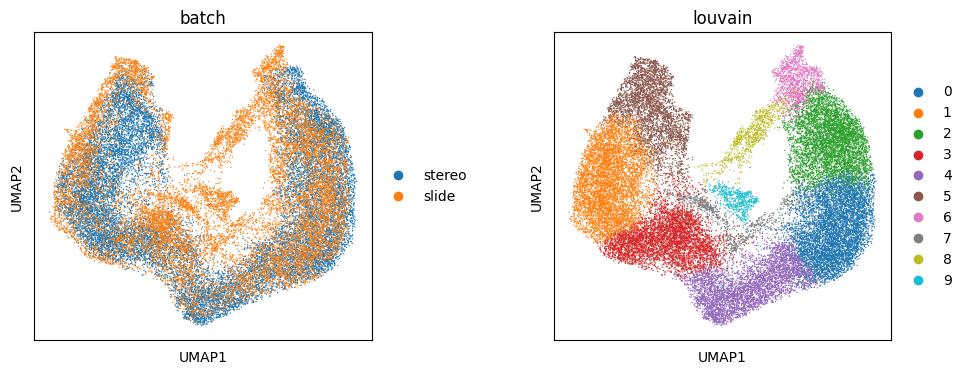

In [8]:
embedding = pd.DataFrame(embedding)
import matplotlib.pyplot as plt
print(embedding.shape)
#var = pd.DataFrame(index=spatial_result.columns)
obs = adata.obs
embedding.index = obs.index

adata_x = ad.AnnData(embedding,obs=obs)
# adata_x.obsm['X_pca_old'] = adata.obsm['X_pca'].copy()
adata_x.obsm['spatial'] = adata.obsm['spatial']
adata_x.obsm['spamc'] = adata_x.X

# adata_x.obsm['spaceFlow'] = embedding_x
# adata_x.obsm['X_pca'] = embedding_x
sc.pp.neighbors(adata_x, use_rep='spamc',random_state=0)
sc.tl.louvain(adata_x, key_added="louvain", resolution=0.66,random_state=150)
sc.tl.umap(adata_x)



plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_x,color=["batch",'louvain'], wspace=0.4) #UMAP基础散点图

In [9]:
from model import batch_entropy_mixing_score
batch_entropy_mixing_score = batch_entropy_mixing_score(adata_x.obsm['spamc'],np.array(adata_x.obs['batch']))

# print('FOSCTTM score: '+str(FOSCTTM_score))
print('Batch Entropy score: '+str(batch_entropy_mixing_score))

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}
Batch Entropy score: 0.46289443586048473
